# Network visualization

This notebook constructs a network visualization connecting bacterial apecies to metabolic compounds.

In [37]:
# Preliminaries
%matplotlib inline

import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from IPython.display import display, HTML

def widen_notebook():
    display(HTML("<style>.container { width:100% !important; }</style>"))
widen_notebook()

In [38]:
# data files
!ls ../data

edges     edges.zip


In [39]:
edges_txt = "../data/edges/ihmp/edges.txt"
metabolites_txt = "../data/edges/ihmp/metabolite_metadata.txt"
microbes_txt = "../data/edges/ihmp/microbe_metadata.txt"

In [44]:
# Read data files into lists of dictionaries
def split_commas(line):
    return line.strip().split("\t")

def CSVtodicts(filename):
    f = open(filename)
    result = []
    headers = split_commas(f.readline())
    for line in f.readlines():
        values = split_commas(line)
        dictionary = dict(zip(headers, values))
        result.append(dictionary)
    return result

edges = CSVtodicts(edges_txt)
metabolites = CSVtodicts(metabolites_txt)
microbes = CSVtodicts(microbes_txt)

len(edges), len(metabolites), len(microbes)

(600, 40886, 562)

In [46]:
# Convert numeric column
def float_column(name, dicts):
    for d in dicts:
        d[name] = float(d[name])

ew = "cond_logit"
float_column(ew, edges)
edges[10]

{'cond_logit': 5.129806985778424,
 'metabolite': 'C18n_QI5513',
 'microbe': 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Butyricicoccus'}

In [47]:
d_col = 'diagnosis[T.nonIBD]'
float_column(d_col, metabolites)
metabolites[100]

{'HMDB (*Representative ID)': '',
 'Intercept': '-3.5641323270341854',
 'Metabolite': '',
 'Method': 'C18-neg',
 'Pooled QC sample CV': '0.255591787',
 'RT': '0.33',
 'diagnosis[T.UC]': '0.3680441616142343',
 'diagnosis[T.nonIBD]': 0.35672915625546864,
 'm/z': '162.8924',
 'sampleid': 'C18n_QI855'}

In [48]:
float_column(d_col, microbes)
microbes[111]

{'Intercept': '0.3073111187096602',
 'diagnosis[T.UC]': '-0.0699298184537378',
 'diagnosis[T.nonIBD]': 0.15122810292498468,
 'featureid': 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_xylanisolvens'}

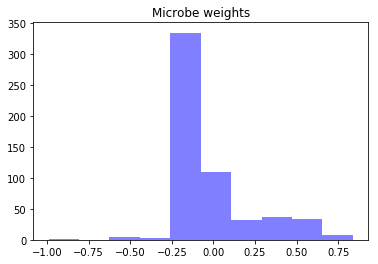

'#5651a8'

In [49]:
# Data distribution histograms and color mappings
from jp_gene_viz import color_scale

def column_histogram(dictionaries, title, column=d_col):
    weights = [m[column] for m in dictionaries]
    num_bins = 10
    n, bins, patches = plt.hist(weights, num_bins, facecolor='blue', alpha=0.5)
    plt.title(title)
    plt.show()
    low_color = color_scale.clr(255,0,0)
    high_color = color_scale.clr(0,123,255)
    colorizer = color_scale.ColorInterpolator(low_color, high_color, min(weights), max(weights))
    return colorizer

microbe_colorizer = column_histogram(microbes, "Microbe weights")
microbe_colorizer.interpolate_color(0.22)

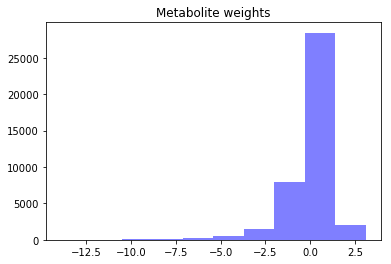

'#2b66d3'

In [50]:
metabolite_colorizer = column_histogram(metabolites, "Metabolite weights")
metabolite_colorizer.interpolate_color(0.22)

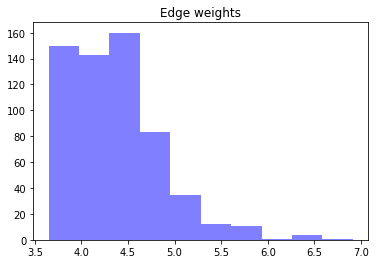

In [51]:
_ = column_histogram(edges, "Edge weights", ew)

In [52]:
# Abbreviate names.
abbreviations = {}
rabbrev = {}

def abbreviate(name, limit=12):
    result = name
    if name in abbreviations:
        return abbreviations[name]
    if len(name) > limit:
        if "|" in name:
            result = name.split("|")[-1]
        if "__" in result:
            result = name.split("__")[-1]
        if "_" in result:
            chunks = result.split("_")
            chunks = [c[0:1].upper()+c[1:4].lower() for c in chunks]
            result = "".join(chunks)
    result = result[:limit]
    x = result
    count = 0
    while result in rabbrev:
        count+=1
        result = x + ":" + str(count)
    abbreviations[name] = result
    rabbrev[result] = name
    return result

abbreviate('k__Viruses|p__Viruses_noname|c__Viruses_noname|o__Viruses_noname')

'ViruNona'

In [56]:
# name abbreviation mappings.
def microbe_name_dict(dicts):
    return dict([abbreviate(d['featureid']), d] for d in dicts)

name2microbe = microbe_name_dict(microbes)
name2microbe.items()[15]

('Verrucomicro:1',
 {'Intercept': '0.785784066784001',
  'diagnosis[T.UC]': '-0.11705301219458253',
  'diagnosis[T.nonIBD]': 0.6498781769301116,
  'featureid': 'k__Bacteria|p__Verrucomicrobia|c__Verrucomicrobiae'})

In [66]:
def metabolite_name_dict(dicts):
    #def f(x):
    #if x['Metabolite'] == '':
    #    return x['sampleid']
    #else:
    #    return x['Metabolite']
    return dict([abbreviate(d['sampleid']), d] for d in dicts)

In [67]:
name2metabolite = metabolite_name_dict(metabolites)
name2metabolite.items()[32]

('C8p_QI28355',
 {'HMDB (*Representative ID)': '',
  'Intercept': '-0.90594426035425',
  'Metabolite': '',
  'Method': 'C8-pos',
  'Pooled QC sample CV': '0.510418331',
  'RT': '3.29',
  'diagnosis[T.UC]': '-4.415580539094426',
  'diagnosis[T.nonIBD]': -1.0232884099782105,
  'm/z': '940.5417',
  'sampleid': 'C8p_QI28355'})

In [68]:
# Construct the network graph from the edges.
from jp_gene_viz import dGraph
G = dGraph.WGraph()
for e in edges:
    G.add_edge(abbreviate(e["microbe"]), abbreviate(e["metabolite"]), e[ew], e)

In [69]:
# Construct the network widget from the graph
from jp_gene_viz import dNetwork
dNetwork.load_javascript_support()
N = dNetwork.NetworkDisplay()
N.load_data(G)

In [70]:
# Configure and display the network

N.labels_button.value = True
N.size_slider.value = 1000

# colorize the nodes based on weights (hacky, sorry)
dg = N.display_graph
for node_name in dg.node_weights:
    svg_name = dg.node_name(node_name)
    if node_name in name2metabolite:
        d = name2metabolite[node_name]
        value = d[d_col]
        N.color_overrides[svg_name] = metabolite_colorizer.interpolate_color(value)
        #print svg_name, N.color_overrides[svg_name]
        #break
    else:
        d = name2microbe[node_name]
        value = d[d_col]
        N.color_overrides[svg_name] = microbe_colorizer.interpolate_color(value)

N.draw()
N.show()

SEJveChjaGlsZHJlbj0oVkJveChjaGlsZHJlbj0oRHJvcGRvd24obGF5b3V0PUxheW91dCh3aWR0aD11JzE1MHB4JyksIG9wdGlvbnM9KCdTVkcnLCAnY2FudmFzJyksIHZhbHVlPSdTVkcnKSzigKY=
